# Определение возраста покупателей

**Описание целей и задачи проекта**

Заказчик сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
 - контролировать добросовестность кассиров при продаже алкоголя.
 
Задача: Построить модель, которая по фотографии определит приблизительный возраст человека.

**Описание данных**

Данные взяты с сайта ChaLearn Looking at People. 

Они находятся в папке /datasets/faces/.

В распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age.


**План работы**

1. Загрузить и подготовить данные.
2. Сделать исследовательский анализ.
2. Обучить нейронную сеть, метрика качества *MAE* должна быть не более 7. 
3. Сделать выводы.

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
id_age = pd.read_csv('/datasets/faces/labels.csv')
id_age.head(4)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50


In [3]:
id_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
id_age.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


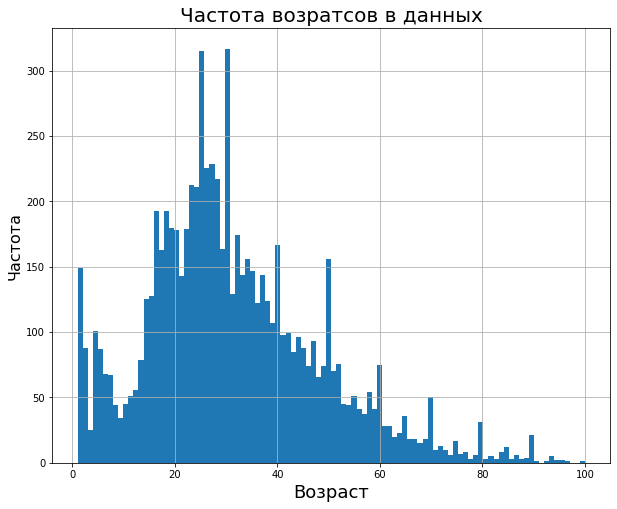

In [5]:
plt.title('Частота возратсов в данных', fontsize=20)
plt.xlabel('Возраст', fontsize=18)
plt.ylabel('Частота', fontsize=16)
id_age['real_age'].hist(bins=100, figsize=[10, 8]);

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=id_age,
                                                   directory='/datasets/faces/final_files/',
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='raw',
                                                   seed=42)

Found 7591 validated image filenames.


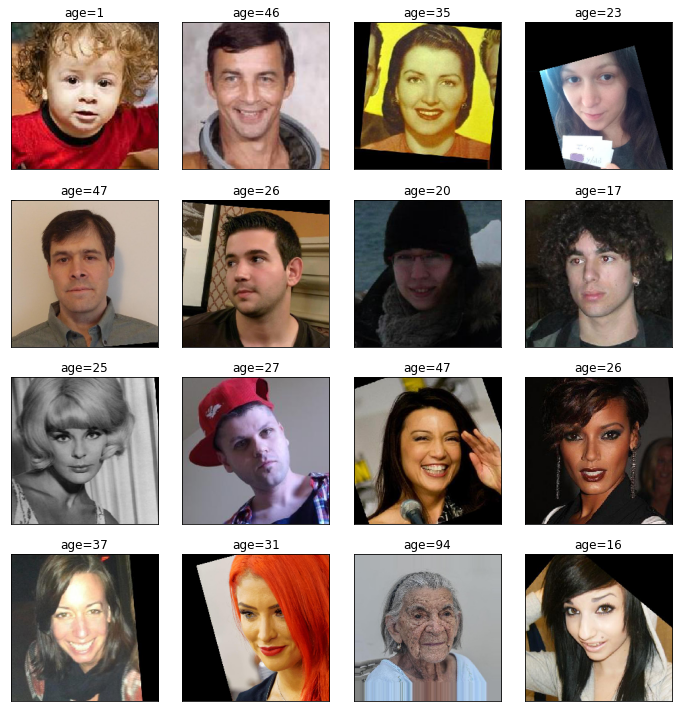

In [7]:
a,b = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(a[i])
    plt.xticks([])
    plt.yticks([])
    plt.title('age='+ str(b[i]))
    plt.tight_layout()

### Вывод

В выборке 7591 изображение. В данных присутсвуют черно-белые изображения. Ориентация фоторграфий верная: лица ориентированы сверху вниз ("от макушки до подборотка") и не требуется менять эту ориентацию, наблюдаются повороты на 5-20 градусов и растянутые фото. Размеры изображений тоже различаются, есть только лицо, есть в полный рост.

Для увеличения тренировочной выборки при обучении модели повернём фотографии по горизонтали и тем самым увеличим тренировочную выборку в два раза. Размер изображений при загрузке приведем к общему виду: 224 x 224 пикселя.

Покупатели с возрастом, к примеру, 1 год или 100 лет выглядят "странно", но у нас задача определить их возраст, так что в данном случает это не считаю выбросоми. Данных для обучения достаточно.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

Для обучения я выбрал свёрточную нейронную сеть на архетиктуре ResNet. Т к у нас задача регрессии, то выходной слой должен состоять из одного нерона.

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, horizontal_flip=True)
    train_gen_flow = datagen.flow_from_dataframe(dataframe=pd.read_csv(path + 'labels.csv'),
                                                       directory=path + '/final_files',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=42)
    return train_gen_flow

def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(dataframe=pd.read_csv(path + 'labels.csv'),
                                                       directory=path + '/final_files',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='raw',
                                                       subset='validation',
                                                       seed=42)
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='imagenet', 
                        include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=100, activation='relu'))
    model.add(Dense(units=60, activation='relu'))
    model.add(Dense(units=40, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data, 
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

```
Epoch 1/10
178/178 - 61s - loss: 12.1097 - mae: 12.1112 - val_loss: 18.3637 - val_mae: 18.2842
Epoch 2/10
178/178 - 51s - loss: 7.1971 - mae: 7.1969 - val_loss: 21.7126 - val_mae: 21.6223
Epoch 3/10
178/178 - 51s - loss: 6.1263 - mae: 6.1258 - val_loss: 15.0530 - val_mae: 14.9822
Epoch 4/10
178/178 - 51s - loss: 5.5590 - mae: 5.5591 - val_loss: 10.5889 - val_mae: 10.5590
Epoch 5/10
178/178 - 49s - loss: 5.0629 - mae: 5.0633 - val_loss: 6.6368 - val_mae: 6.6388
Epoch 6/10
178/178 - 49s - loss: 4.6149 - mae: 4.6152 - val_loss: 6.2438 - val_mae: 6.2188
Epoch 7/10
178/178 - 47s - loss: 4.2557 - mae: 4.2559 - val_loss: 6.1725 - val_mae: 6.1646
Epoch 8/10
178/178 - 48s - loss: 3.9238 - mae: 3.9238 - val_loss: 6.0982 - val_mae: 6.0771
Epoch 9/10
178/178 - 54s - loss: 3.7087 - mae: 3.7090 - val_loss: 6.0869 - val_mae: 6.0537
Epoch 10/10
178/178 - 48s - loss: 3.4678 - mae: 3.4673 - val_loss: 6.2072 - val_mae: 6.2016
60/60 - 9s - loss: 6.2072 - mae: 6.2016
Test MAE: 6.2016
```

## Анализ обученной модели

В ходе выполнения проекта данные были подготовлены и загружены. Сделан исследовательский анализ, в данных присутсвуют:
- черно-белые изображения
- риентация фоторграфий верная: лица ориентированы сверху вниз ("от макушки до подборотка") и не требуется менять эту ориентацию
- наблюдаются повороты на 5-20 градусов и растянутые фото
- размеры изображений тоже различаются, есть только лицо, есть в полный рост.

Обучена нейронная сеть ResNet50. ResNet — самое популярное решение для любых задач компьютерного зрения. Модель может работать с большим количеством данных, при этом хорошо обучаться и уменьшать скорость обучения по сравнения с полносвязными сетями. В нашей работе применена модель ResNet50 - это значит что сделано 50 повторений блоков с принципом «свёртка увеличивает число каналов, а MaxPool уменьшает размерность». В конце сделаны три полносвязных слоя с функцией ReLU(чтобы отрицательный возраст приравнивает к нулю), на выходе один рейрон с конечным предсказанием возраста.

Тестовая метрика MAE = 6,2, это говорит о том, что модель по фотографии определяет возраст с погрешностью 6,2 года. Этого достаточно для решения поставленой задачи определения возраста.

Данная модель решает задачу с погрешностью 6 лет, значит необходимо разработать систему дополнительной проверки при случаях когда человеку, к примеру 17 лет и продажа алкоголя ему запрещенв, а модель выдаст 23 года. Плюс модель только определяет возраст, но не запрещает продавать. Можно дополнить ее этими функциями ограничения при внедрении. 